<a href="https://colab.research.google.com/github/aishwary247/Deep-Learning/blob/main/04_PyTorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Torch and setting up Device-Agnostic Code

In [1]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#Get Data

Our dataset is a subst of Food 101 dataset.
Food 101 has 100 different classes of food and 1000 images per class (750 training, 250 testing)
Our data has 3 different classes of food and only 10 percent images(75 training, ~25 testing)

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists.. skipping download")
else:
  print(f"{image_path} does not exist, creating one. . .")
  image_path.mkdir(parents = True, exist_ok= True)

data/pizza_steak_sushi directory already exists.. skipping download


In [5]:
# Dowload pizza steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data . . .")
  f.write(request.content)

with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip" , "r") as zip_ref:
  print("Unzipping pizza, steak and sushi date. . .")
  zip_ref.extractall(image_path)

Unzipping pizza, steak and sushi date. . .


# 2. Becoming one with the Data

In [6]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents. """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


## 2.1 Visualizing and image

  1. Get all of the image paths
  2. Pick a random image path using Python's random.choice()
  3. Get the image class name using 'pathlib.Path.parent.stem'
  4. Since we're working with images, lets's open the image with Python's PIL
  5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/540882.jpg
Image class: pizza
Image height: 384
Image width: 512


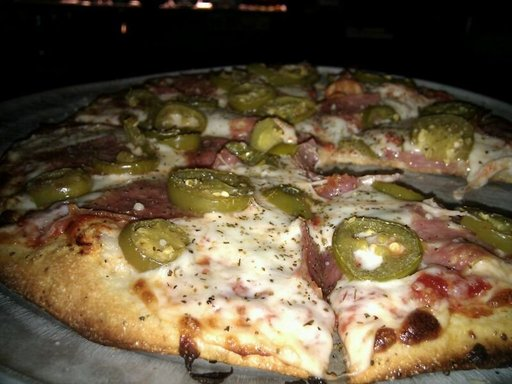

In [8]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img


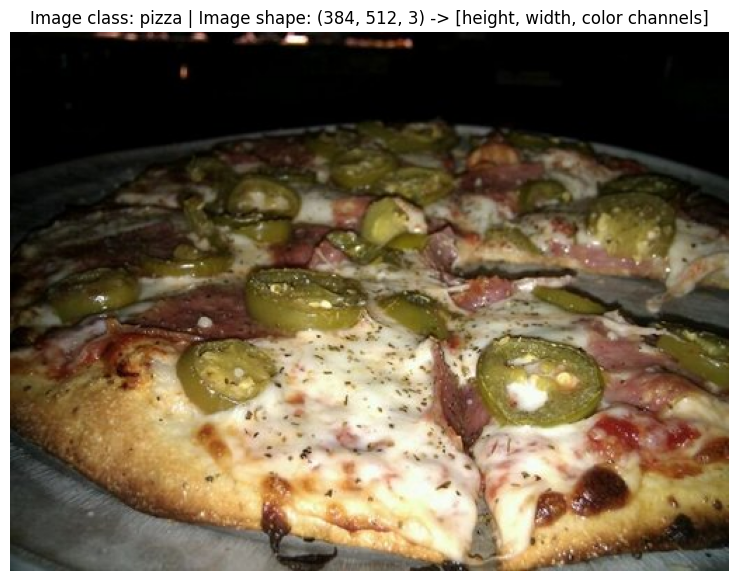

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize= (10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False);

array([[[ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[48, 62, 62],
        [50, 64, 64],
        [53, 67, 67],
        ...,
        [46, 55, 50],
        [47, 53, 49],
        [45, 54, 49]],

       [[44, 60, 59],
        [47, 63, 62],
        [51, 67, 66],
        ...,
        [43, 54, 48],
        [43, 52, 47],
        [42, 53, 47]],

       [[36, 52, 51],
        [40, 56, 55],
        [45, 61, 60],
        ...,
        [43, 54, 48],
        [42, 53, 47],
        [42, 53, 47]]], dtype=uint8)
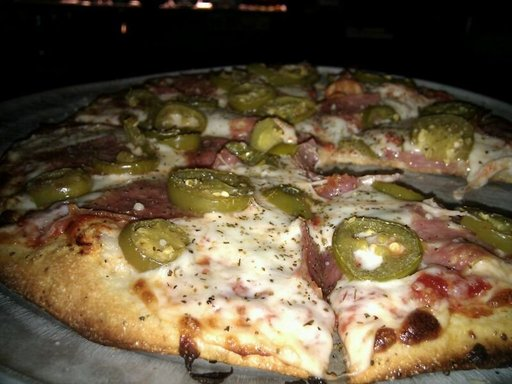

In [10]:
img_as_array

# 3. Transforming data
  Before we can use our data we need to
  1. Transform the images into tensors
  2. Turn it into `torch.utils.data.Dataset` and subsequently `into torch.utils.data.Dataloader`, we will call these Dataset and Dataloader

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [14]:
data_transform(img)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
         ...,
         [0.2314, 0.2118, 0.2196,  ..., 0.1804, 0.1686, 0.1569],
         [0.2588, 0.2510, 0.2980,  ..., 0.1882, 0.2078, 0.2078],
         [0.1961, 0.2196, 0.2784,  ..., 0.2471, 0.2667, 0.2275]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
         ...,
         [0.2588, 0.2392, 0.2275,  ..., 0.1922, 0.1804, 0.1725],
         [0.3098, 0.3020, 0.3451,  ..., 0.2039, 0.2353, 0.2431],
         [0.2275, 0.2510, 0.3098,  ..., 0.2824, 0.3098, 0.2784]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

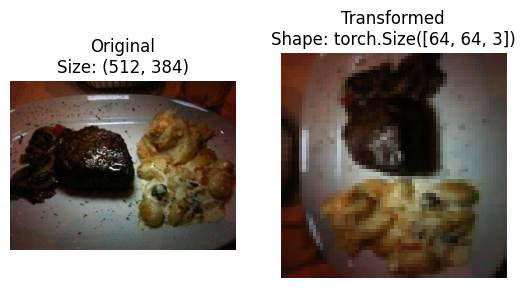

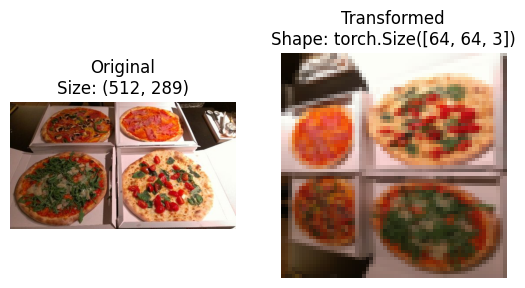

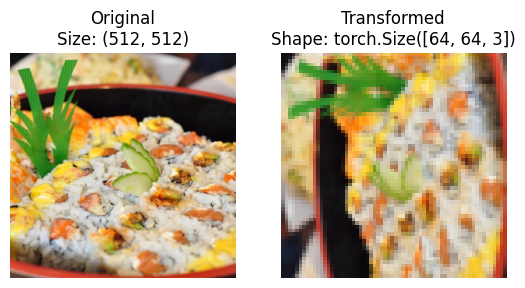

In [15]:
def plot_transformed_images(image_paths : list, transform, n=3, seed = None):
  if seed :
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k= n)
  for image_path in random_image_paths :
    with Image.open(image_path) as f :
      fig, ax = plt.subplots(nrows =1, ncols=2)
      ax[0].imshow(f)
      ax[0].axis(False)
      ax[0].set_title(f"Original\nSize: {f.size}")

      #Transform image
      t_image = transform(f).permute(2,1,0)
      ax[1].axis("off")
      ax[1].set_title(f"Transformed\nShape: {t_image.shape}")
      ax[1].imshow(t_image)

plot_transformed_images(image_path_list, data_transform)


# 4. Option-1 : Loading Image data using `ImageLoader`

  We can load image classification data using `torchvision.dataset.ImageFolder - `


In [16]:
# Set up train and testing path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Use image folder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # transform for data
                                  target_transform = None) # transform for label/target
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

## 4.1 Turn loaded images into `DataLoader's`

In [22]:
import os
os.cpu_count()

2

In [23]:
len(train_data), len(test_data)

(225, 75)

In [24]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b8274b68460>,
 <torch.utils.data.dataloader.DataLoader at 0x7b8276777d90>)

In [25]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [26]:
img , label = next(iter(train_dataloader))
img.shape, label.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# Replicating the TinyVVG architecture

In [39]:
class TinyVVG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)  # default stride value same as kernel size
      )


    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2) # default stride value same as kernel size

    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=13*13*10,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.layer1(x)
    # print(x.shape)
    x = self.layer2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.layer2(self.layer1(x))) # benefits from operator fusion



In [28]:
torch.manual_seed(42)
model_0 = TinyVVG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVVG(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [29]:
model_0(img)

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.1558e-02, -3.9539e-03,  1.4496e-02],
        [ 2.1985e-02,  4.3876e-04,  1.1393e-02],
        [ 2.0922e-02, -2.2525e-03,  9.8050e-03],
        [ 2.0182e-02, -2.1775e-03,  9.5757e-03],
        [ 1.9161e-02, -1.6678e-03,  6.6199e-03],
        [ 2.2961e-02, -3.0607e-03,  4.7193e-03],
        [ 2.0645e-02,  1.3476e-03,  6.4783e-03],
        [ 1.9283e-02, -5.5838e-03,  1.2924e-02],
        [ 2.1924e-02, -1.5791e-03,  9.7267e-03],
        [ 1.8243e-02, -2.6362e-04,  7.6277e-03],
        [ 1.9626e-02,  1.1067e-03,  8.9761e-03],
        [ 2.2252e-02,  1.6674e-05,  7.7792e-03],
        [ 2.2356e-02, -3.7492e-03,  9.9149e-03],
        [ 2.3936e-02, -2.9916e-03,  1.0278e-02],
        [ 2.1939e-02, -9.8321e-04,  1.0026e-02],
        [ 2.0885e-02, -4.0333e-03,  1.1070e-02],
        [ 1.8856e-02,  4.5290e-03,  7.4783e-03],
        [ 2.1972e-02,  1.8999e-04,  1.0116e-02],
        [ 2.1274e-02, -3.5762e-03,  8.7465e-03],
        [ 2.2410e-02, -1.3742e-03,  8.0150e-03],
        [ 2.0803e-02

In [30]:
!pip install torchinfo

In [31]:
from torchinfo import summary

model = model_0
batch_size = 32
summary(model, input_size=(batch_size, 3, 64, 64))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVVG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

##4.2 Creating Train and Test **Loop**

In [32]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [33]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

## 4.3 Creating a `train()` function to combine `train_step()` and `test_step()`


In [34]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## 4.4 Train and evaluate model 0


In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVVG
model_0 = TinyVVG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 1.1064 | Train acc: 0.3125 | Test loss: 1.0989 | Test acc: 0.2812
Epoch: 1 | Train loss: 1.1003 | Train acc: 0.3320 | Test loss: 1.0696 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0881 | Train acc: 0.3633 | Test loss: 1.0829 | Test acc: 0.4413
Epoch: 3 | Train loss: 1.0873 | Train acc: 0.3867 | Test loss: 1.0597 | Test acc: 0.6042
Epoch: 4 | Train loss: 1.0667 | Train acc: 0.4062 | Test loss: 1.0691 | Test acc: 0.5341
Epoch: 5 | Train loss: 1.0332 | Train acc: 0.4531 | Test loss: 1.0166 | Test acc: 0.5028
Epoch: 6 | Train loss: 0.9847 | Train acc: 0.4336 | Test loss: 0.9354 | Test acc: 0.5938
Epoch: 7 | Train loss: 0.9490 | Train acc: 0.5742 | Test loss: 1.0353 | Test acc: 0.4242
Epoch: 8 | Train loss: 0.9247 | Train acc: 0.5938 | Test loss: 1.0896 | Test acc: 0.3532
Epoch: 9 | Train loss: 1.0117 | Train acc: 0.4492 | Test loss: 1.0373 | Test acc: 0.4138
Epoch: 10 | Train loss: 0.8790 | Train acc: 0.5273 | Test loss: 0.9781 | Test acc: 0.5634
Epoch: 11 | Train lo

In [52]:
model_0_results


{'train_loss': [1.106372356414795,
  1.1003407686948776,
  1.0881276726722717,
  1.0872628092765808,
  1.066683366894722,
  1.0331749320030212,
  0.9847050085663795,
  0.9490298926830292,
  0.9247239381074905,
  1.0117482244968414,
  0.8790271654725075,
  0.9386690706014633,
  0.8008095026016235,
  0.9024047553539276,
  0.7866444811224937,
  0.7415995318442583,
  0.7771461233496666,
  0.7701696678996086,
  0.7917012870311737,
  0.7948634400963783,
  0.8084107860922813,
  0.8199789151549339,
  0.7567346915602684,
  0.8794573545455933,
  0.683147557079792,
  0.7287828624248505,
  0.6712273955345154,
  0.6789797507226467,
  0.6416166122071445,
  0.817643478512764,
  0.7107925266027451,
  0.63537354208529,
  0.6392582701519132,
  0.6824550852179527,
  0.6695920675992966,
  0.7275125458836555,
  0.8484227433800697,
  0.8646420314908028,
  0.7195193618535995,
  0.7293671518564224,
  0.81070626527071,
  0.7508545219898224,
  0.7002137899398804,
  0.7237738594412804,
  0.7661599069833755,
  0.

## 4.5 Plot the loss curves of Model 0
A loss curve is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [53]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [47]:
import typing

In [54]:
def plot_loss_curves(results: typing.Dict[str, list[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

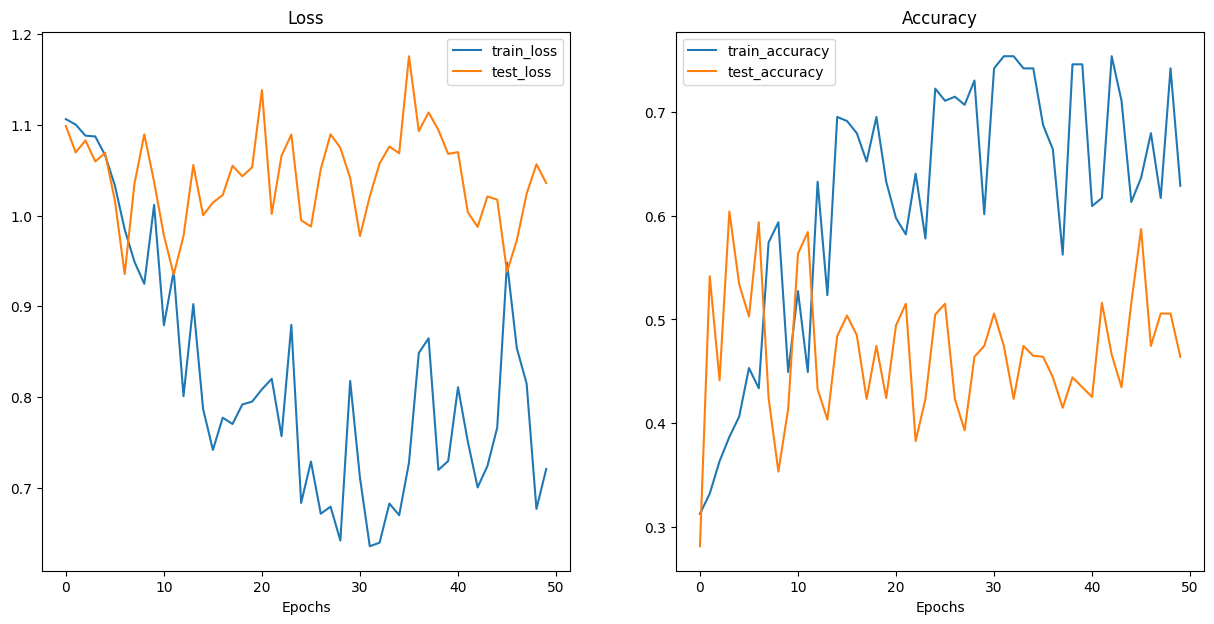

In [55]:
plot_loss_curves(model_0_results)

# 5. Putting custom image prediction together: building a function
Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [59]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

In [60]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

In [62]:
import torchvision


In [63]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

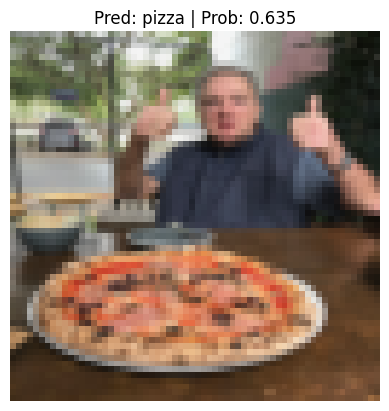

In [64]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

# 6. Other forms of transforms (data augumentation)  

In [35]:
from torchvision import transforms

train_transform = transforms.Compose([ transforms.Resize(size = (224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                       transforms.ToTensor()
])
test_transform = transforms.Compose([transforms.Resize(size = (224,224)),
                                    transforms.ToTensor()
])

In [36]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/256592.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1647351.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1761285.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/75537.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1966300.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1736968.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1621763.jpg')]

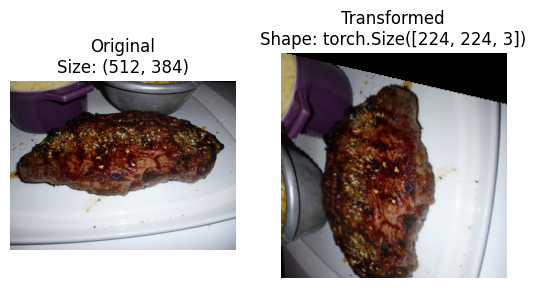

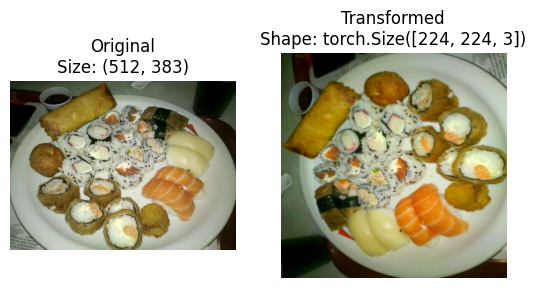

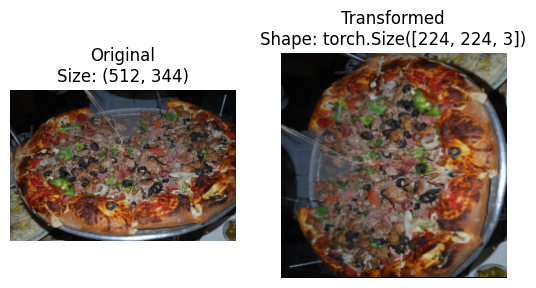

In [37]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)